In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Just for in this notebook
import sys
sys.path.append('../assignment1/to_hand_in/')

import some_routines as sr
from tqdm import tqdm_notebook as tqdm

Logistic regression is similar to linear regression, where we fit a model $$\hat{y} = h_\theta(\vec{x}) = \vec{\theta}^T \vec{x} + b$$ with parameters $\vec{\theta}$ and $b$ to features $\vec{x}$. The difference with linear regression is that we now use the sigmoid function as activation function, to limit the output between 0 and 1. The sigmoid function is defined as
\begin{equation}
\sigma(y) = \frac{1}{1+e^{-y}}
\end{equation}
It has the nice property that 
\begin{equation}\label{eq:derivsigm}
\frac{\partial }{\partial y} \sigma(y) = \sigma(y)(1-\sigma(y)),
\end{equation}
which allows us to calculate the derivative with already known values.
Thus the prediction function for logistic regression is
\begin{equation}
\hat{y} = h_\theta(\vec{x}) = \sigma( \vec{\theta}^T \vec{x} + b)
\end{equation}

We optimize the prediction function by minimizing the loss function. The loss function is defined as the binary cross-entropy loss function:
\begin{equation}
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} y_i \log(h_\theta(\vec{x}_i)) + (1-y_i) \log(1-h_\theta(\vec{x}_i))
\end{equation}
where $m$ is the number of training examples.

The loss function shall be minimized using gradient descent:
\begin{equation}
\theta_j = \theta_j - \alpha \frac{\partial J(\theta) }{\partial \theta_j}
\end{equation}
where $\alpha$ a hyperparameter called the learning rate. 
Using the property of the sigmoid function (Eq. \ref{eq:derivsigm}), the derivative of the loss function with respect to the parameters $\theta$ is then by
\begin{equation}
\frac{\partial J(\theta) }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta(\vec{x_i}) - y_i) x_{i,j}
\end{equation}



where $x_{i,j}$ denotes the $j$-th feature of example $i$. 

In Python, we can vectorize all computations except the iterations of gradient descent by using matrices and dot products. We initialize $\theta$ as an ($n\times 1$) array and $X$ as an ($m\times$n) array. Because of \textit{Numpy} broadcasting $b$ can just be a float. The prediction of all training examples is then given by a dot product
\begin{equation}
\hat{y} = \sigma(X\cdot\theta + b)
\end{equation}
In this way, $\hat{y}$ is an $m\times 1$ array containing the predictions of all the training examples.

The backpropagation can also be vectorized, since we can calculate the derivatives as follows
\begin{equation}
\begin{split}
\frac{\partial J}{\partial b} = \frac{1}{m} \sum (\hat{y} - y) \\
\frac{\partial J}{\partial \theta} = \frac{1}{m} X^T \cdot (\hat{y}-y)
\end{split}
\end{equation}
where $y$ is now the ($m\times 1$) array containing the true labels. In this setup $\frac{\partial J}{\partial \theta}$ is an $n\times 1$ array containing the derivatives with respect to the $\theta$ array. 

We choose to standardize all features to have 0 mean and unit variance. For this standardization, we ignore the missing values. After standardization, we make sure that all missing values are set to TODO

In [90]:
def sigmoid(X):
    """
    Calculate the sigmoid function for vector X
    """
    return 1/(1+np.exp(-X))

In [91]:
def bincrossent(y, yhat):
    """
    Given yhat and y
    Calculate the binary cross entropy
    """
    m = np.shape(yhat)[0]
        
    return -1/m *( np.dot(y.T,np.log(yhat)) + np.dot(
                                        (1-y).T,np.log(1-yhat)) )

In [92]:
def gradient_descent(w, X, b, y, alpha, calcLoss=False):
    """
    Perform one iteration of gradient descent.
    n is amount of features.
    m is amount of examples.
    
    w     -- (nx1) array -- weights  (also called parameters theta)
    X     -- (mxn) array -- features 
    b     -- float       -- bias   
    y     -- (mx1) array -- true labels 
    alpha -- float       -- learning rate
    calcLoss -- bool -- whether to calculate and return the loss value
    
    Returns 
    w -- updated weights
    b -- updated biases
    
    """
    m = np.shape(X)[0]
    invm = 1/m
    
    # prediction
    yhat = sigmoid(np.dot(X,w)+b)
    # error
    err = yhat - y
    # derivative w.r.t the weights
    dw = invm * np.dot(X.T,err)
    # derivative w.r.t. the bias
    db = invm * np.sum(err)
    
    # Update weights and biases
    w -= alpha*dw
    b -= alpha*db
    
    if calcLoss:
        # calculate loss before the update
        loss = bincrossent(y,yhat)
        return w, b, loss
    else:        
        return w, b

In [93]:
def make_labels(T90):
    """
    Reads in the T90 values and assigns a label based on T90
    short (0) if T90 <= 10
    long  (1) if T90 > 10
    """
    labels = np.array(T90>10,dtype='float')[:,np.newaxis] # return the necessary shape
    return labels

def standardize(features, setmean=False):
    """
    Standardize all features such that they have 
    mean 0 and variance 1.
    
    If setmean, set all missing features to the mean of the feature
    and add another column of 1's where it is missing and 0 where
    it is not missing, to track the influence of the missing data.
    """
    for j in range(features.shape[1]):
        # all missing features
        missing = features[:,j] == -1
        # Ignore missing data for calculation of mean and variance
        featcol = features[:,j][np.invert(missing)]
        mean = np.mean(featcol)
        std = np.std(featcol)
        # Standardize the column
        features[:,j] -= mean
        features[:,j] /= std
        if setmean:
            # Put missing on zero, which is the mean of the feature
            features[:,j][missing] = 0
            # add another column
            features = np.append(features,(missing^1)[:,np.newaxis],axis=1)
        else:
            # Put missing back to -1
            features[:,j][missing] = -1
            
    return features

def check_missing_data(features, labels):
    missing = features == -1
    # sum across rows to see how many features are missing
    nummiss = np.sum(missing,axis=0)
    print (f"Number of missing values per column: {nummiss}")
    # decide to drop last three columns
    features = features[:,:-3]
    
    # For the rest of the columns, check how many entries have all features
    missing = features == -1
    
    # Mask array that is true where data is not missing
    mask = np.sum(missing,axis=1) == 0
    # The amount of rows without missing values
    nomiss = np.sum(mask)
    print (f"Amount of datapoints that have all {features.shape[1]} features: {nomiss}")
    
    return features, labels
    
    

In [94]:
# Use only all except first 2 columns, those contain GRB and some index
# The columns indicate
# redshift, T90, log(M*/Msun), SFR, log(Z/Zsun), SSFR, AV
data = np.loadtxt('./GRBs.txt', comments='#', usecols=(2,3,4,5,6,7,8))
# Feature column labels
flabels = ['Redshift', 'logM', 'SFR', 'logZ', 'SSFR', 'AV']

# Labels (1 or 0) are based on T90 values
T90 = data[:,1] 
labels = make_labels(T90) # shape (235,1)

# Check the zeroR prediction
print (f"Predicting everything as most abundant class gives accuracy: {np.sum(labels)/len(labels):.2f}")

# Features are all things that are not T90
features = np.copy(data[:,[0,2,3,4,5,6]]) # shape (235,6)

# print ("Shape of the data", features.shape)

# First check missing values, decide to drop last three columns
features, labels = check_missing_data(features, labels)

# Append all squared features, track missing values
missing = features == -1
sqfeatures = features**2.
sqfeatures[missing] = -1
features = np.append(features,sqfeatures,axis=1)

# Then standardize the data, setting missing values to the mean of the data
setmean = True
features = standardize(features,setmean)


Predicting everything as most abundant class gives accuracy: 0.77
Number of missing values per column: [  0 141 154 191 220 213]
Amount of datapoints that have all 3 features: 77


In [95]:
# Split into training and test set
split = int(len(features)*3/4)

train = features[:split]
test = features[split:]

features = train
testlabels = labels[split:]
labels = labels[:split]

[0.69314718 0.69077656 0.68844449 0.68615033 0.68389342 0.68167315
 0.67948888 0.67734    0.67522591 0.67314601]


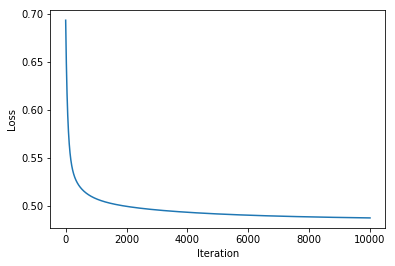

Amount predict Long 167.0
Amount predict Short 9.0
Amount Long:  135.0
Amount Short:  41.0
Amount incorrect: 38.0
Accuracy 0.7840909090909091


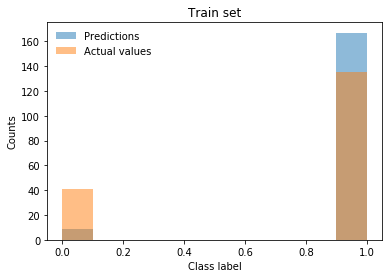

Test set:
Amount predict Long 56.0
Amount predict Short 3.0
Amount Long:  47.0
Amount Short:  12.0
Amount incorrect: 11.0
Accuracy 0.8135593220338984


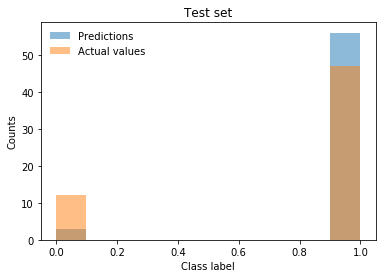

In [98]:
# Initialize weights and biases
w = np.zeros((features.shape[1],1))
b = 0

numit = 10000
loss = np.zeros(numit)
alpha = 0.01
for i in range(numit):
    w, b, loss[i] = gradient_descent(w, features, b, labels, alpha, True)


print (loss[:10])
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# Final prediction
yhat = sigmoid(np.dot(features,w)+b)
# Decision boundary at 0.5
yhat[yhat > 0.5] = 1
yhat[yhat < 0.5] = 0
print ("Amount predict Long", np.sum(yhat))
print ("Amount predict Short", len(yhat)-np.sum(yhat))

print ("Amount Long: ", np.sum(labels))
print ("Amount Short: ", len(labels)-np.sum(labels))

print ('Amount incorrect:', np.sum(np.abs(yhat-labels)))
print ('Accuracy', 1 - np.sum(np.abs(yhat-labels))/len(labels))

plt.title('Train set')
plt.hist(yhat.flatten(),label='Predictions',alpha=0.5)
plt.hist(labels.flatten(),label='Actual values',alpha=0.5)
plt.legend(frameon=False)
plt.xlabel('Class label')
plt.ylabel('Counts')
plt.show()

if len(test) > 0:
    print ("Test set:")
    # Final prediction on test set
    yhat = sigmoid(np.dot(test,w)+b)
    # Decision boundary at 0.5
    yhat[yhat > 0.5] = 1
    yhat[yhat < 0.5] = 0
    print ("Amount predict Long", np.sum(yhat))
    print ("Amount predict Short", len(yhat)-np.sum(yhat))

    print ("Amount Long: ", np.sum(testlabels))
    print ("Amount Short: ", len(testlabels)-np.sum(testlabels))

    print ('Amount incorrect:', np.sum(np.abs(yhat-testlabels)))
    print ('Accuracy', 1 - np.sum(np.abs(yhat-testlabels))/len(testlabels))
    
    plt.title('Test set')
    plt.hist(yhat.flatten(),label='Predictions',alpha=0.5)
    plt.hist(testlabels.flatten(),label='Actual values',alpha=0.5)
    plt.legend(frameon=False)
    plt.xlabel('Class label')
    plt.ylabel('Counts')
    plt.show()

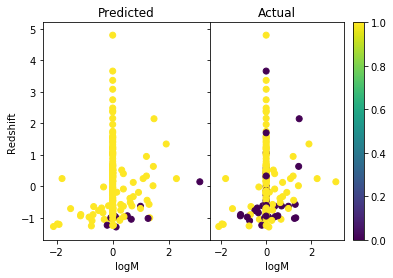

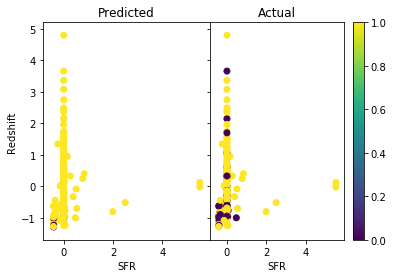

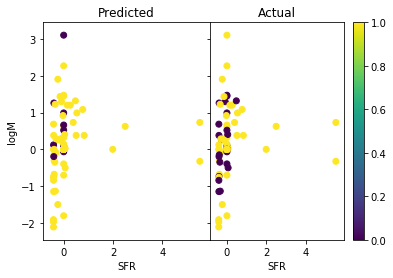

In [99]:
yhat = sigmoid(np.dot(features,w)+b)
yhat_predict = yhat>0.5

for i in range(0,3):
    for j in range(0,i+1):
        if i != j:
            fig, axes = plt.subplots(1,2,sharex=True,sharey=True)
            plt.subplots_adjust(wspace=0)
            ax = axes[0]
            ax.set_title("Predicted")
            im = ax.scatter(features[:,i],features[:,j],c=yhat_predict[:,0])
            ax.set_xlabel(flabels[i])
            ax.set_ylabel(flabels[j])

            ax = axes[1]
            ax.set_title("Actual")
            im = ax.scatter(features[:,i],features[:,j],c=labels[:,0])
            plt.xlabel(flabels[i])
            fig.colorbar(im, ax=ax)
            plt.show()

From inspecting the 2D projected plots, no clear regions can be found where the bursts are short as opposed to long. Therefore, the logistic regression algorithm does not perform much better than the ZeroR prediction of classifying evertything as long. This is worsened by the fact that for all features except redshift, most of the values are missing. Combining features only makes sense if both features are not missing so effectively we only have very little features to work with.
The network now uses the redshift, star formation rate and mass of the host galaxy as first and second order features. We have decided to include the second order features as it is very clear from Figure \ref{fig:predictions} that a first order model will not be able to distinguish the short from the long bursts.